<a href="https://colab.research.google.com/github/Kathy42xu/Blockhouse_quant_assessment/blob/main/Blockhouse_assessment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Blockhouse_assessment, Kathy Xu

#Task 1： Construct and code the linear OW model and nonlinear AFS model, and visualize the distri- bution of price impact based on the given data. (33 pt)


**Dataloading and estimate lambda and beta**


Firstly plot some data to gain some insights

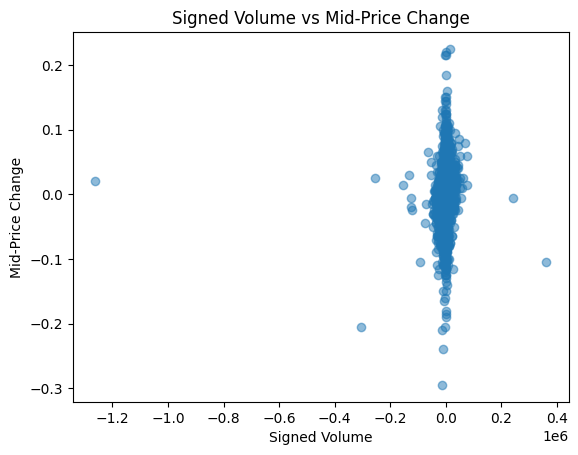

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv("/merged_data.csv")

# Compute mid-price changes
data['mid_price_change'] = data['mid_price'].diff()

# Filter rows with valid values
data = data.dropna(subset=['Signed Volume', 'mid_price_change'])
data = data[(data['Signed Volume'] != 0) & (np.abs(data['mid_price_change']) > 1e-6)]

# Plot
plt.scatter(data['Signed Volume'], data['mid_price_change'], alpha=0.5)
plt.title("Signed Volume vs Mid-Price Change")
plt.xlabel("Signed Volume")
plt.ylabel("Mid-Price Change")
plt.show()




The data is balanced around zero, meaning positive and negative volumes and price changes cancel each other out, the median of these ratios can indeed be zero. This will affect my lambda estimation (=0). Instead, use linear regression to tackle this problem

In the following code, I aimed to quantify how trade volumes influence price movements in financial markets.

**Parameter Estimation:**• Lambda (𝜆): Represents the sensitivity of price changes to trade volumes. For both models,𝜆 was estimated using linear regression.

In the Linear OW Model, 𝜆 was directly associated with the signed trade volume. In contrast, the Nonlinear AFS Model incorporated a power-law relationship by adjusting the trade volume with a nonlinearity parameter (𝑝), typically set to 0.5 to reflect diminishing returns on larger trades.

Beta (𝛽): Denotes the rate at which the impact of a trade decays over time. 𝛽 was calibrated separately for each model by minimizing the difference between the model's predicted price impacts and the actual observed price changes.

This optimization ensured that each model accurately captured the temporal dynamics of price adjustments following trades.

The Linear OW Model assumed a direct proportionality between trade volume and price impact, while the Nonlinear AFS Model allowed for a more flexible relationship, accounting for varying effects of trade sizes. After computing the impacts, I visualized the results through time series plots and distribution histograms.

Loading and preprocessing data...

Calibrating parameters for Linear OW Model with p=1.0...
Lambda (p=1.0): 1.8229707503388496e-07
Intercept (p=1.0): 0.00016793045241375452

Calibrating beta for Linear OW Model...
Calibrated beta for Linear OW Model: 1.0

Computing price impact for Linear OW Model...


Computing Linear Model: 100%|██████████| 27706/27706 [00:00<00:00, 36873.89it/s]



Calibrating parameters for Nonlinear AFS Model with p=0.5...
Lambda (p=0.5): 5.169519315590941e-05
Intercept (p=0.5): 0.0005411678711441791

Calibrating beta for Nonlinear AFS Model...
Calibrated beta for Nonlinear AFS Model: 1.0000153520968573

Computing price impact for Nonlinear AFS Model...


Computing Nonlinear Model: 100%|██████████| 27706/27706 [00:01<00:00, 15095.80it/s]



Visualizing price impact distributions...


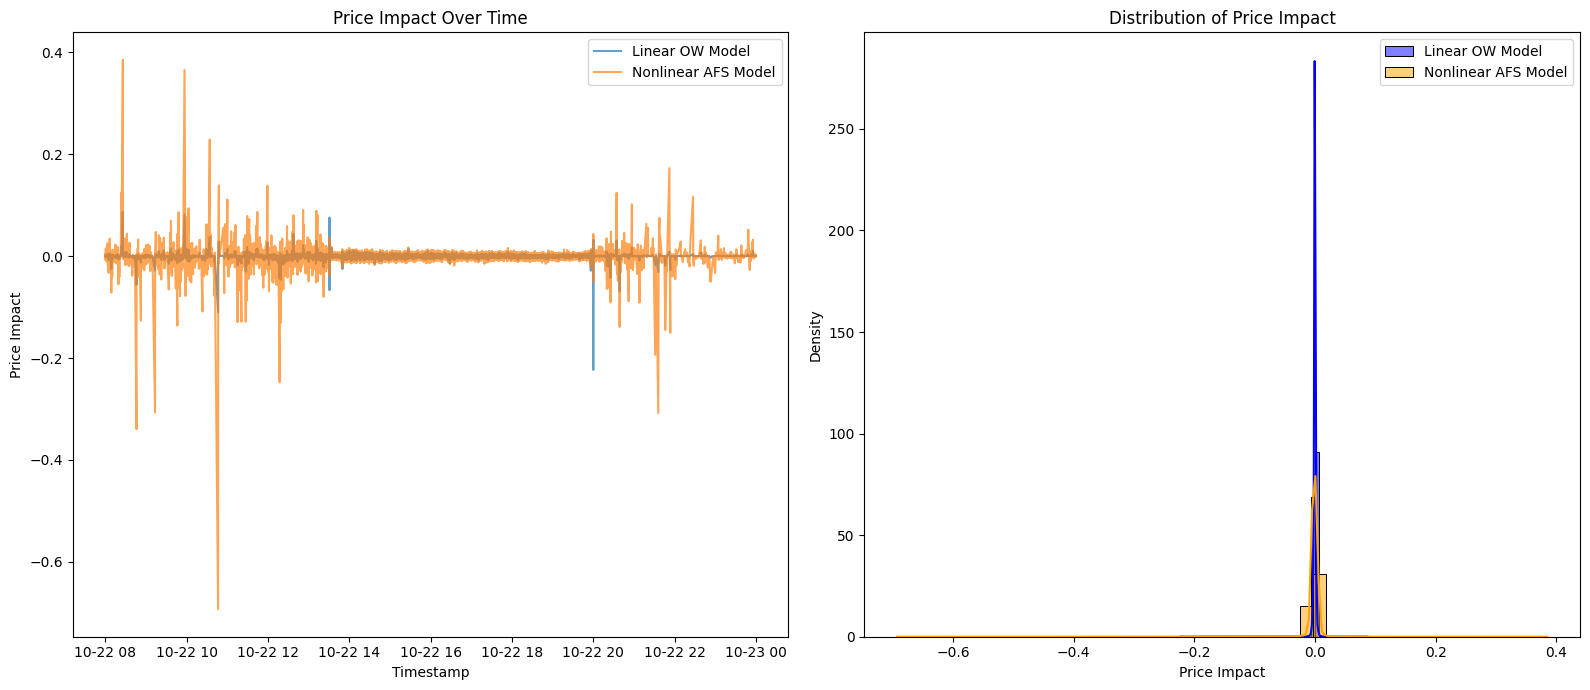

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize
from tqdm import tqdm
from sklearn.linear_model import LinearRegression

pd.options.mode.chained_assignment = None

def load_and_preprocess(filepath):
    """
    Load the dataset and perform preprocessing steps.
    """
    df = pd.read_csv(filepath)

    df['ts_event'] = pd.to_datetime(df['ts_event'])

    # Sort by timestamp
    df = df.sort_values('ts_event').reset_index(drop=True)

    if 'mid_price' not in df.columns:
        df['mid_price'] = (df['best_bid'] + df['best_ask']) / 2

    if 'Signed Volume' not in df.columns:
        df['Signed Volume'] = df['bid_fill'] - df['ask_fill']

    df['delta_mid_price'] = df['mid_price'].diff().fillna(0)

    df['delta_t'] = df['ts_event'].diff().dt.total_seconds().fillna(0)

    return df

def calibrate_lambda_regression(df, p):
    """
    Calibrate lambda using linear regression for a given p.
    For p=1, it's a linear relationship.
    For p=0.5, it's a nonlinear relationship.
    """
    # Prepare data based on p
    if p == 1.0:
        X = df['Signed Volume'].values.reshape(-1, 1)
    else:
        X = (np.sign(df['Signed Volume']) * np.abs(df['Signed Volume'])**p).values.reshape(-1, 1)

    y = df['delta_mid_price'].values

    non_zero_indices = X[:,0] != 0
    X = X[non_zero_indices]
    y = y[non_zero_indices]

    reg = LinearRegression()
    reg.fit(X, y)

    lambda_calibrated = reg.coef_[0]
    intercept = reg.intercept_

    print(f"Lambda (p={p}): {lambda_calibrated}")
    print(f"Intercept (p={p}): {intercept}")

    return lambda_calibrated, intercept

def compute_price_impact(df, lambda_, beta, p):
    """
    Compute price impact using the specified model parameters.
    """
    I_t = np.zeros(len(df))
    decay_factor = np.exp(-beta * df['delta_t'])

    for i in tqdm(range(1, len(df)), desc=f"Computing {'Nonlinear' if p !=1.0 else 'Linear'} Model"):
        if p == 1.0:
            Q = df['Signed Volume'].iloc[i]
        else:
            Q = np.sign(df['Signed Volume'].iloc[i]) * np.abs(df['Signed Volume'].iloc[i])**p
        I_t[i] = decay_factor.iloc[i] * I_t[i-1] + lambda_ * Q * df['delta_t'].iloc[i]

    return I_t

def calibrate_beta(df, lambda_, p=1.0):
    """
    Calibrate beta by minimizing the MSE between model I_t and actual delta_mid_price.
    """
    def mse(beta, df, lambda_, p):
        # Avoid negative or zero beta
        if beta <= 0:
            return np.inf
        I_t = np.zeros(len(df))
        decay_factor = np.exp(-beta * df['delta_t'])

        for i in range(1, len(df)):
            if p == 1.0:
                Q = df['Signed Volume'].iloc[i]
            else:
                Q = np.sign(df['Signed Volume'].iloc[i]) * np.abs(df['Signed Volume'].iloc[i])**p
            I_t[i] = decay_factor[i] * I_t[i-1] + lambda_ * Q * df['delta_t'].iloc[i]

        # Compute MSE with actual price changes
        mse_val = np.mean((I_t - df['delta_mid_price'])**2)
        return mse_val

    # Initial guess for beta
    initial_beta = 1.0

    # Optimization
    result = minimize(mse, x0=initial_beta, args=(df, lambda_, p), bounds=[(1e-5, 10.0)], method='L-BFGS-B')

    if result.success:
        beta_calibrated = result.x[0]
    else:
        raise ValueError("Beta calibration failed.")

    return beta_calibrated

def visualize_price_impact(df, I_linear, I_nonlinear):
    """
    Visualize the distribution of price impact for both models.
    """
    plt.figure(figsize=(16, 7))


    plt.subplot(1, 2, 1)
    plt.plot(df['ts_event'], I_linear, label='Linear OW Model', alpha=0.7)
    plt.plot(df['ts_event'], I_nonlinear, label='Nonlinear AFS Model', alpha=0.7)
    plt.xlabel('Timestamp')
    plt.ylabel('Price Impact')
    plt.title('Price Impact Over Time')
    plt.legend()

    # Histogram
    plt.subplot(1, 2, 2)
    sns.histplot(I_linear, color='blue', label='Linear OW Model', kde=True, stat="density", alpha=0.5, bins=50)
    sns.histplot(I_nonlinear, color='orange', label='Nonlinear AFS Model', kde=True, stat="density", alpha=0.5, bins=50)
    plt.xlabel('Price Impact')
    plt.ylabel('Density')
    plt.title('Distribution of Price Impact')
    plt.legend()

    plt.tight_layout()
    plt.show()

def main():
    filepath = '/merged_data.csv'

    print("Loading and preprocessing data...")
    df = load_and_preprocess(filepath)

    # Define models with their respective p values
    models = {
        'Linear OW Model': 1.0,
        'Nonlinear AFS Model': 0.5
    }

    lambdas = {}
    intercepts = {}
    betas = {}
    impacts = {}

    # Calibrate and compute for each model
    for model_name, p in models.items():
        print(f"\nCalibrating parameters for {model_name} with p={p}...")

        # Calibrate lambda
        lambda_calibrated, intercept = calibrate_lambda_regression(df, p)
        lambdas[model_name] = lambda_calibrated
        intercepts[model_name] = intercept

        # Calibrate beta
        print(f"\nCalibrating beta for {model_name}...")
        beta_calibrated = calibrate_beta(df, lambda_calibrated, p=p)
        betas[model_name] = beta_calibrated
        print(f"Calibrated beta for {model_name}: {beta_calibrated}")

        # Compute price impact
        print(f"\nComputing price impact for {model_name}...")
        I_t = compute_price_impact(df, lambda_calibrated, beta_calibrated, p)
        impacts[model_name] = I_t


    I_linear = impacts['Linear OW Model']
    I_nonlinear = impacts['Nonlinear AFS Model']

    df['I_linear'] = I_linear
    df['I_nonlinear'] = I_nonlinear

    # Visualization
    print("\nVisualizing price impact distributions...")
    visualize_price_impact(df, I_linear, I_nonlinear)


if __name__ == "__main__":
    main()
